In [118]:
import logging
import warnings
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid
from matplotlib.gridspec import GridSpec

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [119]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

from matplotlib.colors import ListedColormap

In [120]:
path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/result_data_RCB/'
fig_path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/figures_RCB/'
years = [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034]

In [121]:
# Helper functions
# def get_power_prod(year):
#     network = networks[year]
#     carrier_list = network.generators.carrier.unique()
#     carrier_list_2 = network.storage_units.carrier.unique()
#     carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
#     production_data = {}
#     first_date = "2013-01-01"
#     second_date = "2013-12-31"
#     for carrier in carriers:
#         production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6

#     df = pd.DataFrame([production_data])
#     df['hydro'] += df.pop('ror')
#     return df

def get_power_prod(year):
    network = networks[year]
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    # for carrier in carriers:
    #     production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6
 
    production_data["CCGT"] = get_snapshot_generation(year, first_date, second_date, "CCGT").sum() /1e6
    production_data["OCGT"] = get_snapshot_generation(year, first_date, second_date, "OCGT").sum() /1e6
    production_data["oil"] = get_snapshot_generation(year, first_date, second_date, "oil").sum() /1e6
    production_data["geothermal"] = get_snapshot_generation(year, first_date, second_date, "geothermal").sum() /1e6
    production_data["hydro"] = get_snapshot_generation(year, first_date, second_date, "hydro").sum() /1e6
    production_data["onwind"] = get_snapshot_generation(year, first_date, second_date, "onwind").sum() /1e6
    production_data["solar"] = get_snapshot_generation(year, first_date, second_date, "solar").sum() /1e6
    production_data["biomass"] = get_snapshot_generation(year, first_date, second_date, "biomass").sum() /1e6
    production_data["ror"] = get_snapshot_generation(year, first_date, second_date, "ror").sum() /1e6
    production_data["load"] = get_snapshot_generation(year, first_date, second_date, "load").sum() /1e6
 
    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year): 
    network = networks[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(year))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(year)
    prod = get_power_prod(year)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]  
    return df

def get_max_output(year):
    network = networks[year]
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year):
    network = networks[year]
    return network.objective /1e6

def get_total_cost(year):
    network = networks[year]
    return (network.statistics.capex().sum() + network.statistics.opex().sum())/1e6

def get_emissions(year):
    network = networks[year]
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_charge(year):
    network = networks[year]
    capacities_discharge = network.links.groupby(by='carrier')['p_nom'].sum()
    capacities_discharge_df = capacities_discharge.to_frame().transpose()
    capacities_discharge_df.index = [year]
    return capacities_discharge_df

def get_installed_capacity_battery(year):
    network = networks[year]
    storage_capacity = network.stores.groupby(by='carrier')['e_nom'].sum()
    storage_capacity_df = storage_capacity.to_frame().transpose()
    storage_capacity_df.index = [year]
    return storage_capacity_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    network = networks[year]
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    network = networks[year]
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year):
    network = networks[year]
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

def get_new_installed(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

def get_new_installed_battery(years):
    capacity = {'Charger':[], 'Discharger':[],'Battery Storage':[], 'year':[]}

    for y in years:
        net=networks[y]

        capacity["year"].append(y)

        charger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery charger', 0)
        charger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery charger', 0)
        capacity['Charger'].append(charger_next_capacity-charger_capacity)

        discharger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery discharger', 0)
        discharger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery discharger', 0)
        capacity['Discharger'].append(discharger_next_capacity-discharger_capacity)

        battery_storage_capacity = net.stores.groupby('carrier').e_nom.sum().get('battery', 0)
        battery_storage_next_capacity = net.stores.groupby('carrier').e_nom_opt.sum().get('battery', 0)
        capacity['Battery Storage'].append(battery_storage_next_capacity-battery_storage_capacity)

    capacity_battery_df = pd.DataFrame(capacity)
    capacity_battery_df.set_index("year", inplace=True)

    return capacity_battery_df

def get_new_installed_lines(years):
    capacity = {'year':[], 'Line':[]}

    for y in years:
        if y != final_year:
            net=networks[y]
            net2=networks[y+1]
            yearly_capacity_change = 0

            for line in net.lines.index:
                if line in net2.lines.index:
                    yearly_capacity_change += net2.lines.loc[line].s_nom - net.lines.loc[line].s_nom
            
            capacity['year'].append(y)
            capacity['Line'].append(yearly_capacity_change)

    capacity_lines_df = pd.DataFrame(capacity)
    capacity_lines_df.set_index("year", inplace=True)
      
    return capacity_lines_df

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Geothermal', 'Battery']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro', 'geothermal', 'battery']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown, brown, grey4, grey1]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Nbattery',  'Lost load', 'Demand']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_marginal_cost(y, carrier):
    network = networks[y]
    marginal_cost= network.generators.loc[network.generators['carrier'] == carrier, 'marginal_cost'].iloc[0]
    return marginal_cost

def get_subsidies():
    actual_cost = {'CCGT': 52.00, 'OCGT': 64.71, 'oil': 130.23}
    subsidies = {}
    for y in years:
        for carrier in ['CCGT', 'OCGT', 'oil']:
            marginal_cost= get_marginal_cost(y, carrier)
            subsidies[(y, carrier)] = actual_cost[carrier] - marginal_cost
    return subsidies

def npv_of_costs(annual_costs, discount_rate):
    return sum(annual_cost / (1 + discount_rate) ** i for i, annual_cost in enumerate(annual_costs))

def calculate_present_value(future_value, year, base_year, discount_rate):
    return future_value / ((1 + discount_rate) ** (year - base_year))


def capital_recovery_factor(lifetime, discount_rate):
    return discount_rate / (1 - (1 + discount_rate) ** -lifetime)

def annual_capex(years):
    capex_df = pd.DataFrame(index=years, columns=['Capex'])
    new_installed_cap = get_new_installed(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    for y in years:
        installed_cap = get_installed_capacity(y)
        installed_bat = get_installed_capacity_battery(y)
        installed_charge = get_installed_capacity_charge(y)
        network = networks[y]
        total_capex = 0

        for carrier in new_installed_cap.columns:
            if carrier != 'hydro':
                capex_value = new_installed_cap.loc[y, carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
                total_capex += capex_value
        for carrier in installed_cap.columns:
            if carrier == 'hydro':
                capex_value = installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == 'ror', 'capital_cost'].iloc[0]
                total_capex += capex_value
            else:
                capex_value = installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
                total_capex += capex_value
        total_capex += installed_bat.loc[y, 'battery'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        total_capex += installed_charge.loc[y, 'battery charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        total_capex += new_installed_bat.loc[y, 'Battery Storage'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        total_capex += new_installed_bat.loc[y, 'Charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        
        if y != final_year:
            total_capex += new_installed_lines.loc[y, 'Line']

        capex_df.loc[y, 'Capex'] = total_capex
    return capex_df #EUR

#def annual_opex(years):
    


In [122]:
def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown, brown, grey4, grey1]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Nbattery', 'Lost load', 'Demand']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

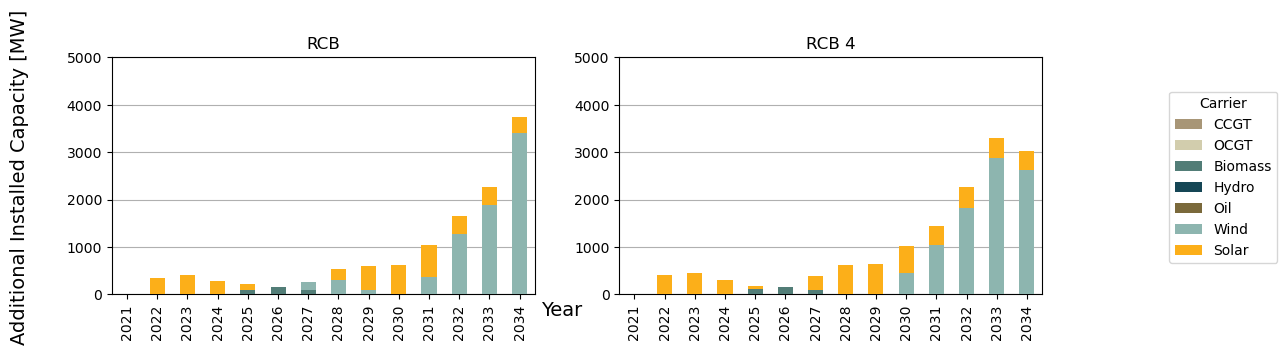

In [123]:
new_capacity_rcb = pd.read_csv(path + 'res_cap_bat_new_capacity.csv', index_col=0)
new_capacity_rcb_4 = pd.read_csv(path + 'res_cap_bat_4_new_capacity.csv', index_col=0)


fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)

axes = axes.flatten()

new_capacity_scenarios = [
    ('RCB', new_capacity_rcb),
    ('RCB 4', new_capacity_rcb_4)
]


for ax, (title, capacity_data) in zip(axes, new_capacity_scenarios):
    capacity_data.plot.bar(stacked=True, ax=ax, color=get_colors(capacity_data.columns), legend=False, zorder=3)
    ax.set_xlabel('')
    ax.set_xticks(range(len(capacity_data.index)))
    ax.set_xticklabels(capacity_data.index, rotation=90)
    ax.set_title(title)
    ax.set_ylim(0, 5000)
    ax.grid(axis='y', zorder=0)

# Set the x-axis label on the last subplot
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Additional Installed Capacity [MW]', va='center', rotation='vertical', fontsize=14)

# Create a single shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')

# Adjust the layout
plt.subplots_adjust(hspace=0.3, top=0.9)
plt.savefig(fig_path + 'new_capacity_rcb_4_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

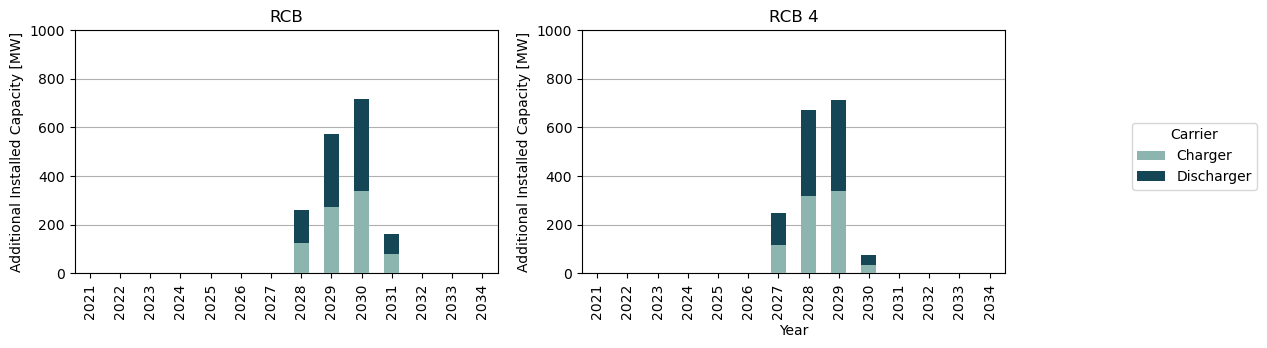

In [141]:
new_bat_capacity_rcb = pd.read_csv(path + 'res_cap_bat_new_battery_capacity.csv', index_col=0)
new_bat_capacity_rcb_4 = pd.read_csv(path + 'res_cap_bat_4_new_battery_capacity.csv', index_col=0)


fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)

axes = axes.flatten()

new_capacity_scenarios = [
    ('RCB', new_bat_capacity_rcb),
    ('RCB 4', new_bat_capacity_rcb_4)
]


for ax, (title, capacity_data) in zip(axes, new_capacity_scenarios):
    capacity_data.drop('Battery Storage', axis=1, inplace=True)
    capacity_data.plot.bar(stacked=True, ax=ax, color=[teal4, teal2, teal3], legend=False, zorder=3)

    ax.set_ylabel('Additional Installed Capacity [MW]')
    ax.set_xlabel('')
    ax.set_xticks(range(len(capacity_data.index)))
    ax.set_xticklabels(capacity_data.index, rotation=90)
    ax.set_title(title)
    ax.set_ylim(0, 1000)
    ax.grid(axis='y', zorder=0)

# Set the x-axis label on the last subplot
axes[-1].set_xlabel('Year')

# Create a single shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')

# Adjust the layout
plt.subplots_adjust(hspace=0.5, top=0.92)
plt.savefig(fig_path + 'new_battery_capacity_4_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

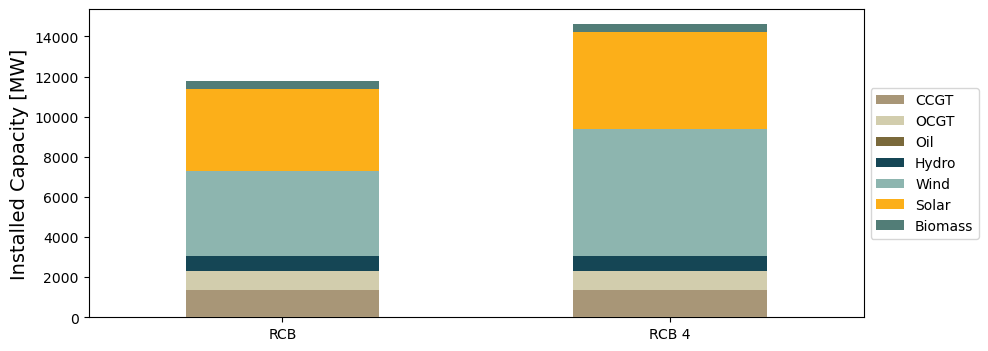

In [125]:
final_capacity_rcb = pd.read_csv(path + 'res_cap_bat_final_capacity.csv', index_col=0)
final_capacity_rcb_4 = pd.read_csv(path + 'res_cap_bat_4_final_capacity.csv', index_col=0)

desired_order = ['CCGT', 'OCGT', 'Oil','Hydro', 'Wind', 'Solar', 'Biomass']

all_data = pd.concat([final_capacity_rcb, final_capacity_rcb_4], axis=0)
all_data.index = ['RCB', 'RCB 4']
all_data = all_data[desired_order]

ax = all_data.plot(kind='bar', stacked=True, figsize=(10, 4), color=get_colors(all_data.columns), legend=False, zorder=3)   
plt.setp(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Installed Capacity [MW]', fontsize=14)   
ax.legend(title='Capacity Type')
plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(fig_path + 'final_capacity_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

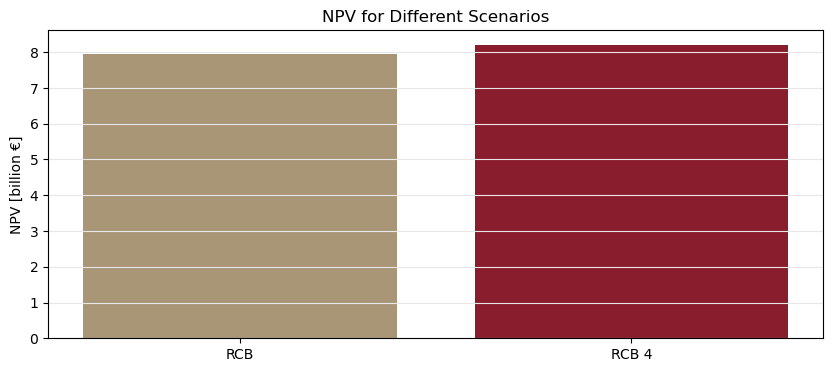

In [126]:
scenarios=['res_cap_bat','res_cap_bat_4']
labels = ['RCB', 'RCB 4']
yearly_costs_all = pd.read_csv(path + 'total_costs.csv')
yearly_costs = yearly_costs_all[scenarios]
total_costs = yearly_costs.sum(axis=0) /1000
total_costs.columns = labels

costs_dict = {label: total_costs[i] for i, label in enumerate(yearly_costs.columns)}
df = pd.DataFrame([costs_dict])

plt.figure(figsize=(10, 4)) 

num_scenarios = len(df.columns)

df.columns = labels
colors = [beige2, red1]

for i, column in enumerate(df.columns):
    # Calculate the positions for the current column
    positions = range(i, len(df) * len(df.columns), len(df.columns))
    plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

# Set the title and labels
plt.title('NPV for Different Scenarios')
plt.ylabel('NPV [billion €]')

# Set x-ticks to be in the middle of the group of bars for each scenario
tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
plt.xticks(range(num_scenarios), df.columns)

#plt.legend()
plt.grid(axis='y', color=grey1)
#plt.ylim(0,10)
plt.savefig(fig_path + 'npv_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

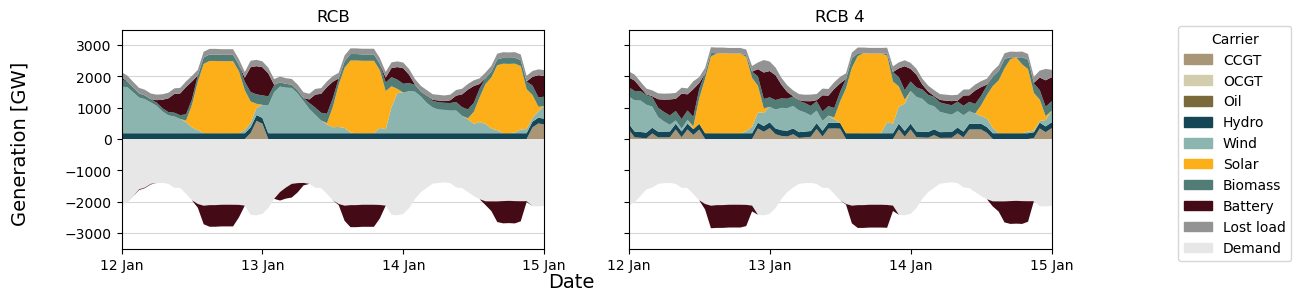

In [127]:
snapshot_rcb = pd.read_csv(path + 'res_cap_bat_snapshots.csv', index_col=0, parse_dates=True)
snapshot_rcb_4 = pd.read_csv(path + 'res_cap_bat_4_snapshots.csv', index_col=0, parse_dates=True)

first_date = "2013-01-12"
second_date = "2013-01-15"
start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

# Create the subplots with 2 columns and 3 rows
fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define your scenarios
scenarios = [
    ('RCB', snapshot_rcb),
    ('RCB 4', snapshot_rcb_4)
]

# Loop through the scenarios to create each subplot
for ax, (title, data) in zip(axes, scenarios):
    # Plot the data using stackplot or any other plotting function
    ax.stackplot(data.index, data['CCGT'], data['OCGT'], data['Oil'], data['Hydro'],
                 data['Wind'], data['Solar'], data['Biomass'], data['Battery'], data['Lost load'],
                 colors=[beige2,beige3,beige1, teal2, teal4,yellow,teal3, brown, grey4], zorder=2)
    ax.stackplot(data.index, data['Demand'], data['Nbattery'], colors=[grey1, brown], zorder=2)
    ax.set_title(title)
    ax.set_xlim(start_date, end_date)
    ax.grid(axis='y', color=grey2)
    ax.set_ylim(-3500,3500)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))

# Set common labels
fig.text(0.5, 0.04, 'Date', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Generation [GW]', va='center', rotation='vertical', ha='center', fontsize=14)
colors=[beige2,beige3,beige1, teal2, teal4,yellow,teal3, brown, grey4, grey1]
labels = [label for label in snapshot_rcb.columns if label != 'Nbattery']  # Exclude 'Nbattery'
patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors) if label != 'Nbattery']
# Create and place the legend
handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')

plt.subplots_adjust(hspace=0.2, bottom=0.15)

# Save the figure
plt.savefig(fig_path + 'snapshots_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

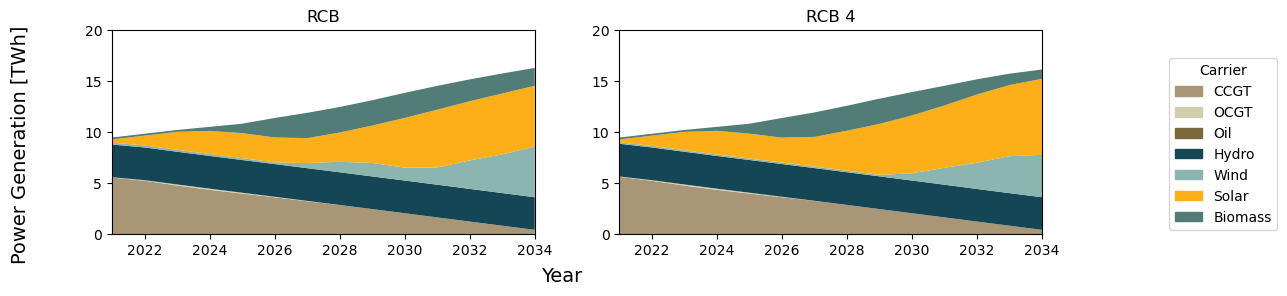

In [137]:
production_RCB = pd.read_csv(path + 'res_cap_bat_production.csv', index_col=0)
production_RCB_4 = pd.read_csv(path + 'res_cap_bat_4_production.csv', index_col=0)


fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharex=True)  # Adjust figsize as needed

# Flatten the 2D array of axes to 1D for easier iteration
axes = axes.flatten()

# Define your scenarios
scenarios = [
    (production_RCB, 'RCB'),
    (production_RCB_4, 'RCB 4')
]

# Loop through the scenarios to create each subplot
for ax, (production_data, title) in zip(axes, scenarios):
    # Ensure production_data is a DataFrame and not a numpy array
    if isinstance(production_data, pd.DataFrame):
        ax.stackplot(production_data.index, production_data.T, 
                     colors=get_colors(production_data.columns), labels=production_data.columns)
        ax.set_ylim(0, 20)
        ax.set_xlim(2021, 2034)
        ax.set_title(title)
    else:
        print(f"Data for {title} is not in DataFrame format.")

# Set the shared x and y-axis labels
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Power Generation [TWh]', va='center', rotation='vertical', fontsize=14)

colors=[beige2,beige3,beige1, teal2, teal4,yellow,teal3, brown, grey4, grey1]
labels = [label for label in production_RCB.columns if label != 'Nbattery']  # Exclude 'Nbattery'
patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors) if label != 'Nbattery']
handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')

plt.subplots_adjust(hspace=0.3, bottom=0.2)

# Save the figure
plt.savefig(fig_path + 'power_prod_4_noiso.png', dpi=300, bbox_inches='tight') 
plt.show()

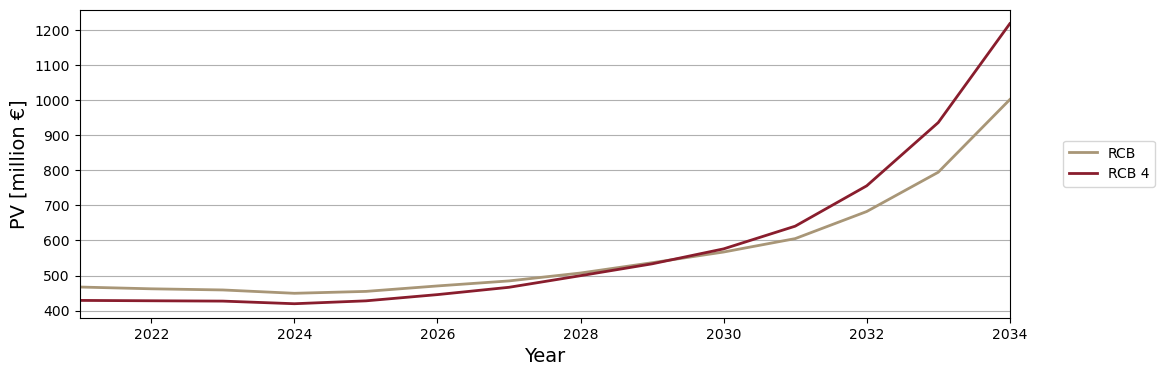

In [129]:
years = list(range(2021, 2035))  # From year 2023 to 2037
yearly_costs.index = years

labels = ['RCB', 'RCB 4']
yearly_costs.columns = labels

colors = [beige2, red1]

plt.figure(figsize=(12, 4))  # Adjust the size as needed
for column in yearly_costs.columns:
    yearly_costs[column].plot(label=column, color=colors[yearly_costs.columns.get_loc(column)], linewidth=2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('PV [million €]', fontsize=14)
plt.legend( loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(axis='y')
#plt.ylim(300,800)
plt.xlim(2021,2034)
plt.savefig(fig_path + 'pv_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

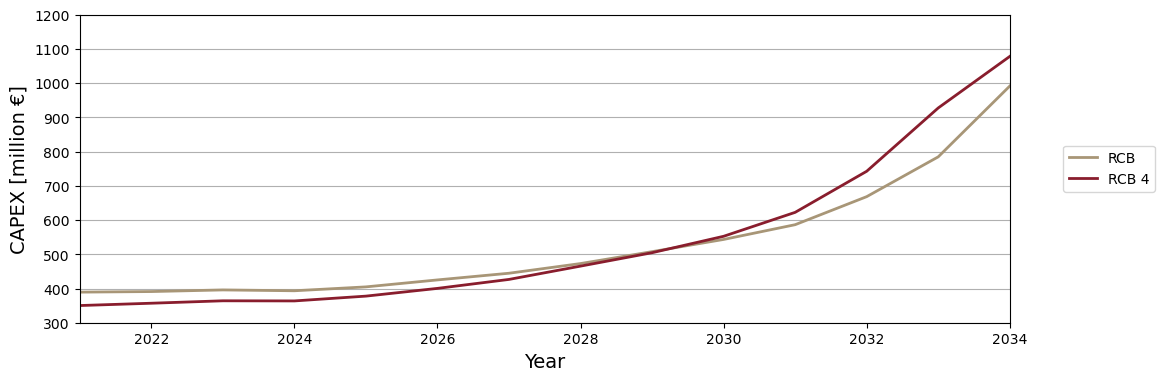

In [130]:
capex_all = pd.read_csv(path + 'capex.csv')
years = list(range(2021, 2035))  # From year 2023 to 2037
scenarios=['res_cap_bat','res_cap_bat_4']
capex = capex_all[scenarios]
capex.index = years

labels = ['RCB', 'RCB 4']
capex.columns = labels

colors = [beige2, red1]

plt.figure(figsize=(12, 4))  # Adjust the size as needed
for column in capex.columns:
    capex[column].plot(label=column, color=colors[capex.columns.get_loc(column)], linewidth=2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('CAPEX [million €]', fontsize=14)
plt.legend( loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(axis='y')
plt.ylim(300,1200)
plt.xlim(2021,2034)
plt.savefig(fig_path + 'capex_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

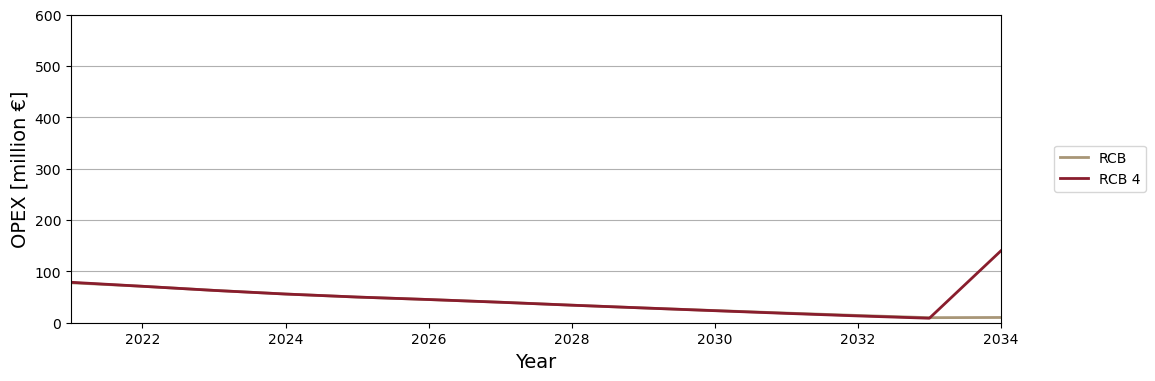

In [131]:
opex_all = pd.read_csv(path + 'opex.csv')

years = list(range(2021, 2035))  # From year 2023 to 2037
opex = opex_all[scenarios]
opex.index = years

opex.columns = labels



plt.figure(figsize=(12, 4))  # Adjust the size as needed
for column in opex.columns:
    opex[column].plot(label=column, color=colors[opex.columns.get_loc(column)], linewidth=2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('OPEX [million €]', fontsize=14)
plt.legend( loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(axis='y')
plt.ylim(0,600)
plt.xlim(2021,2034)
plt.savefig(fig_path + 'opex_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

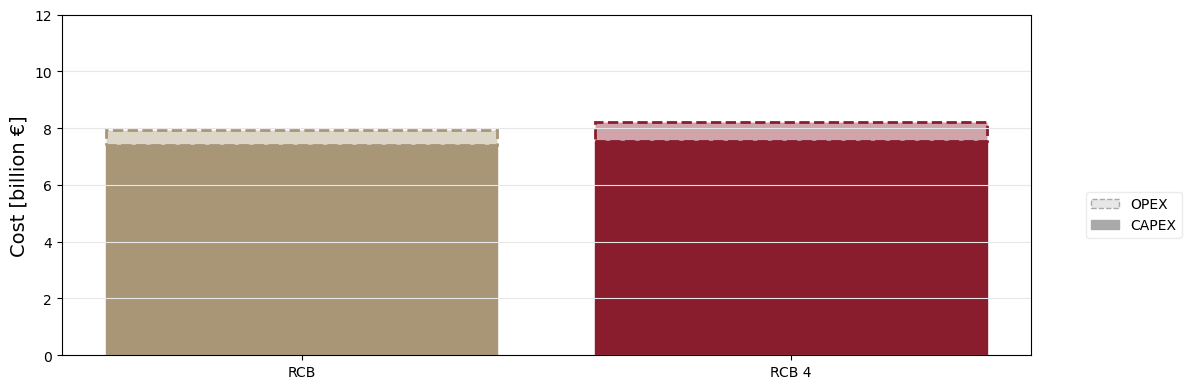

In [132]:
import matplotlib.colors as mcolors
capex_tot = capex.sum() / 1000
capex_tot = pd.DataFrame(capex_tot).T
opex_tot = opex.sum() / 1000
opex_tot = pd.DataFrame(opex_tot).T

fig, ax = plt.subplots(figsize=(12, 4))

# The x-axis positions for each bar
index = np.arange(len(df.columns))


capex_bars = ax.bar(index, capex_tot.iloc[0], label='CAPEX', color=colors, edgecolor=colors)

fill_colors_with_alpha = [mcolors.to_rgba(color, alpha=0.4) for color in colors]  # Fill colors with transparency
solid_edge_colors = [mcolors.to_rgba(color, alpha=1) for color in colors]  # Edge colors without transparency



# Plotting the subsidies bars on top of the total costs (NPV)
opex_bars = ax.bar(index, opex_tot.iloc[0], label='OPEX', bottom=capex_tot.iloc[0], 
                        color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)

ax.set_xticks(index)
ax.set_xticklabels(labels, rotation=0)

# # Set the y-axis label
opex_patch = mpatches.Patch(facecolor=grey1, edgecolor='darkgrey', linestyle='--', linewidth=1, label='OPEX')
capex_patch = mpatches.Patch(color='darkgrey', label='CAPEX')


# Create the legend with custom patches
plt.legend(handles=[opex_patch, capex_patch], loc='best', edgecolor=grey1, bbox_to_anchor=(1.05, 0.5))
plt.ylabel('Cost [billion €]', fontsize=14)
plt.ylim(0,12)
plt.grid(axis='y', color=grey1)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(fig_path + 'capex_opex_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

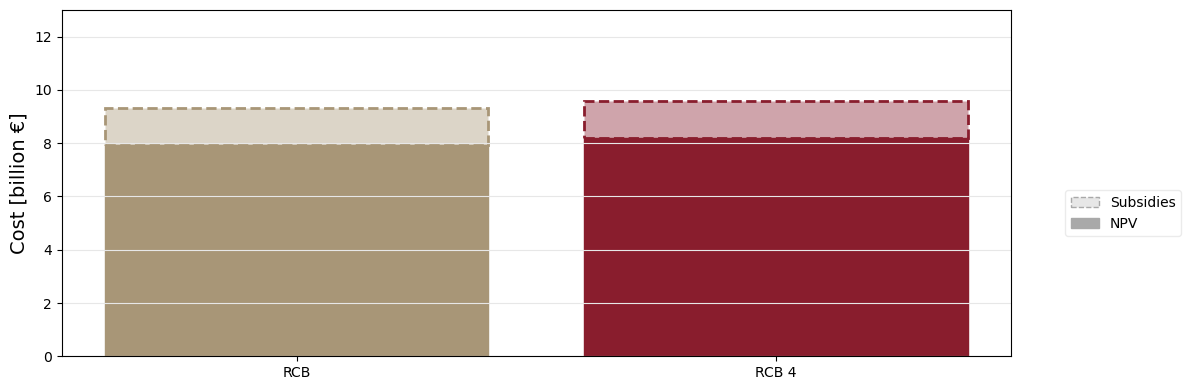

In [133]:
import matplotlib.colors as mcolors
subsidies_all = pd.read_csv(path + 'subsidies.csv')
subsidies = subsidies_all[scenarios]
subsidies = subsidies / 1000


fig, ax = plt.subplots(figsize=(12, 4))

# The x-axis positions for each bar
index = np.arange(len(df.columns))

total_costs_bars = ax.bar(index, df.iloc[0], label='NPV', color=colors, edgecolor=colors)

fill_colors_with_alpha = [mcolors.to_rgba(color, alpha=0.4) for color in colors]  # Fill colors with transparency
solid_edge_colors = [mcolors.to_rgba(color, alpha=1) for color in colors]  # Edge colors without transparency



# Plotting the subsidies bars on top of the total costs (NPV)
subsidies_bars = ax.bar(index, subsidies.iloc[0], label='Subsidies', bottom=df.iloc[0], 
                        color=fill_colors_with_alpha, edgecolor=solid_edge_colors, linestyle='--', linewidth=2)

ax.set_xticks(index)
ax.set_xticklabels(labels, rotation=0)

# # Set the y-axis label
npv_patch = mpatches.Patch(color='darkgrey', label='NPV')
subsidies_patch = mpatches.Patch(facecolor=grey1, edgecolor='darkgrey', linestyle='--', linewidth=1, label='Subsidies')

# Create the legend with custom patches
plt.legend(handles=[subsidies_patch, npv_patch], loc='best', edgecolor=grey1, bbox_to_anchor=(1.05, 0.5))
plt.ylabel('Cost [billion €]', fontsize=14)


# Add a title and a legend

plt.ylim(0,13)
plt.grid(axis='y', color=grey1)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(fig_path + 'costs_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

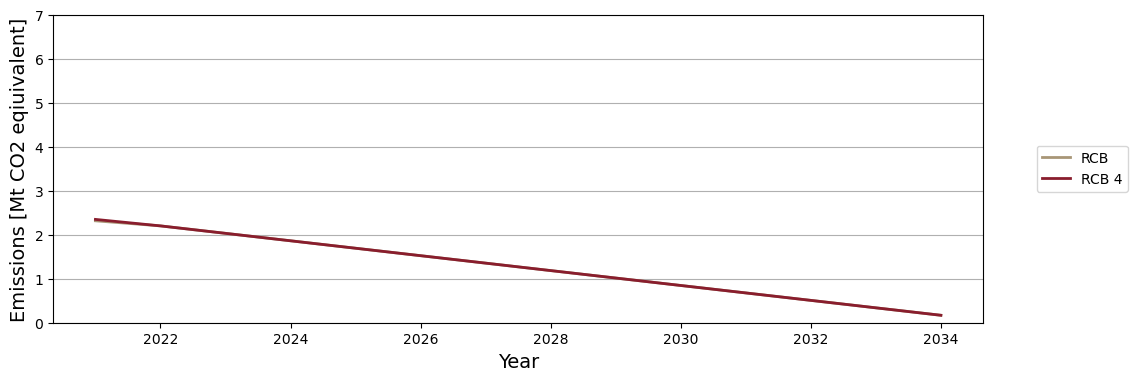

In [134]:
emissions_all = pd.read_csv(path + 'emissions.csv')
emissions = emissions_all[scenarios]
years = list(range(2021, 2035))  # From year 2023 to 2037
emissions.index = years

emissions.columns = labels

plt.figure(figsize=(12, 4))  # Adjust the size as needed
for column in emissions.columns:
    emissions[column].plot(label=column, color=colors[emissions.columns.get_loc(column)], linewidth=2)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Emissions [Mt CO2 eqiuivalent]', fontsize=14)
plt.legend( loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(axis='y')
plt.ylim(0,7)
plt.savefig(fig_path + 'emissions_noiso.png', dpi=300, bbox_inches='tight')
plt.show()

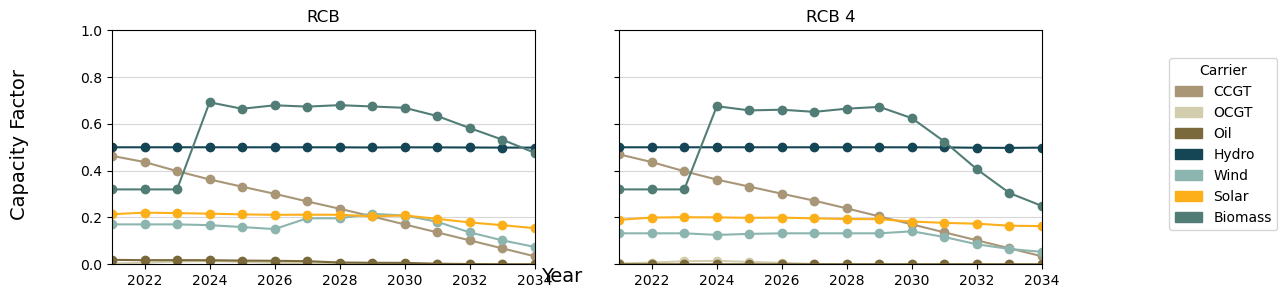

In [135]:
rcb_capacity_factor = pd.read_csv(path + 'res_cap_bat_capacity_factors.csv', index_col=0)
rcb_4_capacity_factor = pd.read_csv(path + 'res_cap_bat_4_capacity_factors.csv', index_col=0)


desired_order = ['CCGT', 'OCGT', 'Oil', 'Hydro', 'Wind', 'Solar', 'Biomass']
rcb_capacity_factor.columns = ['CCGT', 'OCGT', 'Biomass', 'Hydro', 'Oil', 'Wind', 'Solar']
rcb_4_capacity_factor.columns = ['CCGT', 'OCGT', 'Biomass', 'Hydro', 'Oil', 'Wind', 'Solar']


# scenarios = ['base_cap', 'base_cap_4','gradual_cap', 'gradual_cap_4']
# labels = ['Base NZE','Base NZE 4', 'GC NZE', 'GC NZE 4']

# colors = [teal4, red1, teal3, red2]

scenarios = {
    'RCB': rcb_capacity_factor,
    'RCB 4': rcb_4_capacity_factor,
}
colors = get_colors(desired_order)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten if needed

# Plot each scenario in its own subplot
for ax, (title, df) in zip(axes, scenarios.items()):
    for carrier, color in zip(desired_order, colors):
        if carrier in df.columns:
            ax.plot(df.index, df[carrier], label=carrier, color=color, marker='o')
        else:
            print(f"'{carrier}' not found in '{title}' scenario")
    ax.set_ylim(0,1)
    ax.set_xlim(2021,2034)
    ax.set_title(title)
    ax.grid(axis='y', color=grey2)

# Set common labels and title
fig.text(0.5, 0.04, 'Year', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Capacity Factor', va='center', rotation='vertical', fontsize=14)

handles = [mpatches.Patch(color=color, label=label) for label, color in zip(labels, colors)]
fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Carrier')
plt.subplots_adjust(hspace=0.3, bottom=0.1)
plt.savefig(fig_path + 'capacity_factors_4_noiso.png', dpi=300, bbox_inches='tight')
plt.show()